### Plan

- 4.24

look for material/code

write weekly report

Lynn: transformer 

Miko: log reg

Qiling: LSTM

- 4.26

label2 (kmeans，human annotation)

- 4.27-5.2

3 models implementation (LSTM, log reg, transformer)

make table visualization

- 5.2-5.4

final report


### Dataset Overview

In [28]:
import pandas as pd
import numpy as np

In [174]:
df = pd.read_csv('dataset.csv', encoding = 'utf-8')
df.head()

,text,cat,topic
0,SeaWorld’s profits fell by 84% and customers a...,ele,SeaWorld
1,The company teaches dolphins and killer whales...,ele,SeaWorld
2,It says fewer people are going to its parks an...,ele,SeaWorld
3,SeaWorld has been in the news since the 2013 d...,ele,SeaWorld
4,Animal rights organizations say that orcas kep...,ele,SeaWorld


In [302]:
len(df)

7395

In [175]:
# check missing data
print('There are missing values in train data:', df.isnull().values.any())

# more info
print('min len in df: ', len(min(df['text'], key=len)))
print('max len in df: ', len(max(df['text'], key=len)))

There are missing values in train data: False
min len in df:  12
max len in df:  1991


In [235]:
df.groupby('cat').count()

,text,topic
cat,,
adv,2650,2650
ele,2150,2150
int,2595,2595


### Text Pre-Processing

Currently only made process of label `topic`

In [6]:
#Text pre-processing
"""removes punctuation, stopwords, and returns a list of the remaining words, or tokens"""
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Error loading stopwords: <urlopen error [Errno 61]
[nltk_data]     Connection refused>
[nltk_data] Error loading wordnet: <urlopen error [Errno 61]
[nltk_data]     Connection refused>


False

In [31]:
#Cleaning the text
import string
def text_process(text):
    '''
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Return the cleaned text as a list of words
    4. Remove words
    '''
    stemmer = WordNetLemmatizer()
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join([i for i in nopunc if not i.isdigit()])
    nopunc =  [word.lower() for word in nopunc.split() if word.lower() not in stopwords.words('english')]
    return ' '.join([stemmer.lemmatize(word) for word in nopunc])

In [176]:
# topic list
topic = []
for t in df.topic:
    mytopic = text_process(t)
    if (mytopic not in topic):
        topic.append(mytopic)

### Tokenization and Splitting

In [9]:
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [177]:
# tokenization
max_words = 2000
#tokenizer = Tokenizer(num_words=max_words)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(topic)

word_index = tokenizer.word_index
vocab_size = len(word_index)+1
print('Found %s unique tokens.' % len(word_index))

Found 272 unique tokens.


In [191]:
# integer encode the documents
encoded_topic = tokenizer.texts_to_sequences(topic)

# pad documents to a max length of 4 words (no used)
#max_length = 4
#padded_topic = pad_sequences(encoded_topic, maxlen=max_length, padding='post')

### GloVe

In [12]:
from scipy import spatial # embeddings
from sklearn.manifold import TSNE # visualization

from keras.models import Sequential
from keras.layers import Dense, Flatten, Embedding

In [13]:
# create embedding_dict (takes long time)
embeddings_dict = {}
path = ' ' # modify
with open(path + "/glove.6B.50d.txt", 'r', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        token = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[token] = vector

print('Found %s word vectors.' % len(embeddings_dict))

Found 400000 word vectors.


In [13]:
def find_closest_embeddings(embedding, cutoff=25):
    return sorted(embeddings_dict.keys(), key=lambda token: spatial.distance.euclidean(embeddings_dict[token], embedding))


In [14]:
# check
print(find_closest_embeddings(embeddings_dict["twig"] - embeddings_dict["branch"] + embeddings_dict["hand"])[:5])


['fingernails', 'toenails', 'stringy', 'peeling', 'shove']


In [52]:
# check
a = embeddings_dict['door']
b = embeddings_dict['window']
c = embeddings_dict['doos']
dist1 = np.linalg.norm(a-b)
dist2 = np.linalg.norm(a-c)
print('Distance between "door" and "window" is', "%.2f"%(dist1))
print('Distance between "door" and "doos" is', "%.2f"%(dist2))

Distance between "door" and "window" is 2.47
Distance between "door" and "doos" is 8.63


In [56]:
# check
embeddings_dict['seaworld']

array([ 1.142    ,  0.0073347, -0.34446  ,  1.5933   , -0.091562 ,
       -1.0505   , -1.7131   , -1.1196   ,  1.4542   ,  0.69535  ,
        0.020637 ,  0.42931  ,  0.13775  , -0.14925  ,  0.80284  ,
       -0.57233  , -0.34445  ,  0.64497  , -1.2866   , -0.44647  ,
       -0.67966  ,  0.2884   , -0.89558  , -0.12658  , -0.15142  ,
        0.35438  ,  1.1058   , -0.030558 , -0.010526 , -0.92145  ,
       -1.0597   ,  0.23135  , -0.37844  , -1.1166   , -0.090823 ,
       -0.45357  ,  0.036662 , -0.71701  ,  0.049564 ,  0.5766   ,
       -1.0299   , -0.10107  , -0.31862  ,  0.85357  ,  0.57089  ,
       -0.24428  , -0.39856  , -1.2157   ,  0.19371  ,  0.54571  ],
      dtype=float32)

In [205]:
phrase_embeddings_list = []

for phrase_index in encoded_topic:
    if len(phrase_index) != 0:
        length = len(phrase_index)
    embedding_vector = 0
    for i in phrase_index:
        embedding_vector += embeddings_dict[list(word_index)[i-1]]
    embedding_vector = embedding_vector/length
    phrase_embeddings_list.append(embedding_vector)

# convert list to numpy matrix
embeddings_matrix = np.zeros((len(topic), 50))

for i in range(0,len(phrase_embeddings_list)):
    embeddings_matrix[i] = phrase_embeddings_list[i] 

In [267]:
embeddings_matrix

array([[ 1.14199996,  0.0073347 , -0.34446001, ..., -1.21570003,
         0.19371   ,  0.54571003],
       [ 0.26949999, -0.30676001, -1.1681    , ...,  0.39972001,
        -0.19351   ,  0.94417   ],
       [-0.011035  ,  1.70159996,  0.22262999, ..., -0.58366001,
         0.74236   , -0.98032999],
       ...,
       [ 0.84802997, -0.21131   , -0.78253001, ..., -0.4461    ,
        -0.064616  ,  0.16507   ],
       [ 0.289473  ,  0.48859999, -0.71358001, ...,  0.302935  ,
        -0.74865496, -0.20778   ],
       [ 0.54351997, -0.45590001,  0.40635002, ...,  0.164205  ,
         0.33906999,  0.02444999]])

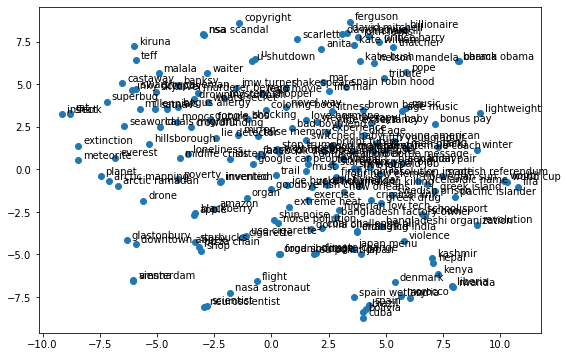

In [230]:
import matplotlib.pyplot as plt

# embedding_matrix visualization
tsne = TSNE(n_components=2, random_state=0)
# words =  list(embeddings_dict.keys()) # for all 40000 vectors
# vectors = [embeddings_dict[word] for word in words]
words = [word for word in topic]
vectors = [embeddings_matrix[i] for i in range(0,len(embeddings_matrix))]
Y = tsne.fit_transform(vectors[:1000])
plt.figure(figsize=(9,6)) 
plt.scatter(Y[:, 0], Y[:, 1])

for label, x, y in zip(words, Y[:, 0], Y[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords="offset points")
plt.show()

In [231]:
len(words),len(vectors)

(186, 186)

In [17]:
model = Sequential()
model.add(Embedding(vocab_size, 8, input_length=max_length))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# summarize the model
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 4, 8)              2184      
_________________________________________________________________
flatten_2 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 2,217
Trainable params: 2,217
Non-trainable params: 0
_________________________________________________________________
None


### K-Means

input: `embeddings_matrix`

* method1

In [244]:
# Clustering the training sentences with K-means technique
from sklearn.cluster import KMeans
wcss=[]
#k = 6
for k in range(1,100):
    modelkmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=0, verbose=False)
    modelkmeans.fit(embeddings_matrix)
    wcss.append(modelkmeans.inertia_)

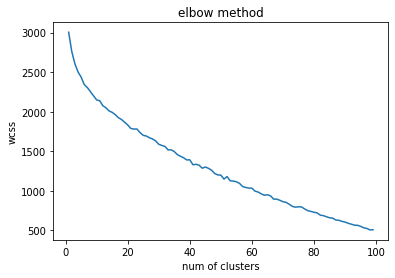

In [245]:
plt.plot(range(1,100),wcss)
plt.title('elbow method')
plt.xlabel('num of clusters')
plt.ylabel('wcss')
plt.show()

* method 2

In [304]:
embeddings_matrix.shape

(186, 50)

In [305]:
len(topic)

186

In [291]:
# https://ai.intelligentonlinetools.com/ml/k-means-clustering-example-word2vec/

from sklearn.cluster import KMeans
from sklearn import metrics

k=3  # modify
kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=0, verbose=False)
kmeans.fit(embeddings_matrix)

labels = kmeans.labels_
centroids = kmeans.cluster_centers_

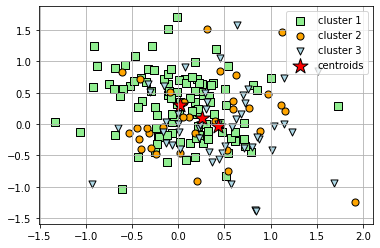

Cluster id labels for inputted data
[2 0 0 2 0 2 2 1 1 0 2 2 0 0 0 1 2 2 2 1 0 0 1 2 0 2 0 2 0 0 1 2 0 0 0 0 0
 1 0 0 0 0 2 2 0 0 1 1 0 0 2 1 0 1 2 0 0 2 1 2 0 0 0 2 0 2 0 0 0 2 0 0 1 0
 2 0 1 0 2 0 0 0 1 0 2 0 2 0 2 0 2 0 0 2 0 1 0 1 2 0 1 2 1 0 0 1 0 0 0 0 2
 0 0 0 0 0 2 0 2 0 2 0 0 0 1 0 2 0 2 2 2 0 0 1 1 2 0 0 2 0 1 0 0 2 0 0 1 2
 0 1 2 2 2 0 0 0 0 2 1 0 1 0 1 0 0 0 0 1 0 2 1 0 0 0 1 1 0 0 0 0 0 0 0 2 2
 0]
Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):
-2606.4155706426945
Silhouette_score: 
0.09119315489451553


<Figure size 432x288 with 0 Axes>

In [308]:
y_km = kmeans.fit_predict(embeddings_matrix)
plt.scatter(
    embeddings_matrix[y_km == 0, 0], embeddings_matrix[y_km == 0, 1],
    s=50, c='lightgreen',
    marker='s', edgecolor='black',
    label='cluster 1'
)

plt.scatter(
    embeddings_matrix[y_km == 1, 0], embeddings_matrix[y_km == 1, 1],
    s=50, c='orange',
    marker='o', edgecolor='black',
    label='cluster 2'
)

plt.scatter(
    embeddings_matrix[y_km == 2, 0], embeddings_matrix[y_km == 2, 1],
    s=50, c='lightblue',
    marker='v', edgecolor='black',
    label='cluster 3'
)

# plot the centroids
plt.scatter(
    kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
    s=250, marker='*',
    c='red', edgecolor='black',
    label='centroids'
)
plt.legend(scatterpoints=1)
plt.grid()
plt.show()
plt.savefig('clustering.png')
print ("Cluster id labels for inputted data")
print (labels)
#print ("Centroids data")
#print (centroids)
 
print ("Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):")
print (kmeans.score(embeddings_matrix))
 
silhouette_score = metrics.silhouette_score(embeddings_matrix, labels, metric='euclidean')
 
print ("Silhouette_score: ") # range from -1 to 1
print (silhouette_score)

In [295]:

label2 = {}
for i in range(0,len(topic)):
    label2[topic[i]] = kmeans.labels_[i]
l1=[]
l2=[]
l3=[]
for label in label2:
    if label2[label] == 0:
        l1.append(label)
    elif label2[label] == 1:
        l2.append(label)
    elif label2[label] == 2:
        l3.append(label)

In [300]:
len(l1),len(l2),len(l3)

(103, 33, 50)

**Label2 category:**
* cluster 1: pop culture
* cluster 2: geography
* cluster 3: nature

**Label2 Error Analysis:**
* lots of abbreviation
* average word vectors if the topic is a phrase

### Questions:

1. how to evaluate result of k-means? (Silhouette)
2. how to choose k?
3. do we need to human annotate label2?

### Next Steps:

1. According to k, get datasets with the same label2
2. Splitting into Training and Test Data for each dataset
3. LSTM, log reg(baseline), transformer

In [297]:
new_df = pd.read_csv('dataset.csv',encoding='utf-8')
new_df.head()

,text,cat,topic,cluster
0,SeaWorld’s profits fell by 84% and customers a...,ele,SeaWorld,2.0
1,The company teaches dolphins and killer whales...,ele,SeaWorld,2.0
2,It says fewer people are going to its parks an...,ele,SeaWorld,2.0
3,SeaWorld has been in the news since the 2013 d...,ele,SeaWorld,2.0
4,Animal rights organizations say that orcas kep...,ele,SeaWorld,2.0
